#ConTextTransformer

This is a demo notebook for a simple multi-modal Transformer model that has been pre-trained on the ConText dataset.

The [Con-Text dataset](https://staff.fnwi.uva.nl/s.karaoglu/datasetWeb/Dataset.html) is built from two sub-categories of the ImageNet dataset: "building" and "place of business". The task is fine-grained classification. The dataset consists of 28 categories (e.g. "Bakery", "Bistro", "Restaurant", "Cafe", "Pizzeria", etc.) with 24,255 images in total.

Using scene text (when available) provides high-level semantic information that is useful for the task. However, not all the images have text in them. Moreover, high variability of text size, location, resolution and style and, uncontrolled environmental settings ( illumination ) make text recognition from this dataset harder.

In this ConTextTransformer demo we first use three pre-trained models for feature extraction: a ResNet50, an OCR, and the FastText word embedding. Then we project the visual (ResNet) and textual (FastText) features to a common dimensionality (Linear Projections) and we feed them into the Tansformer Encoder. Finally, the MLP head takes the output feature of the CLS token and predicts one of the classes with Softmax.

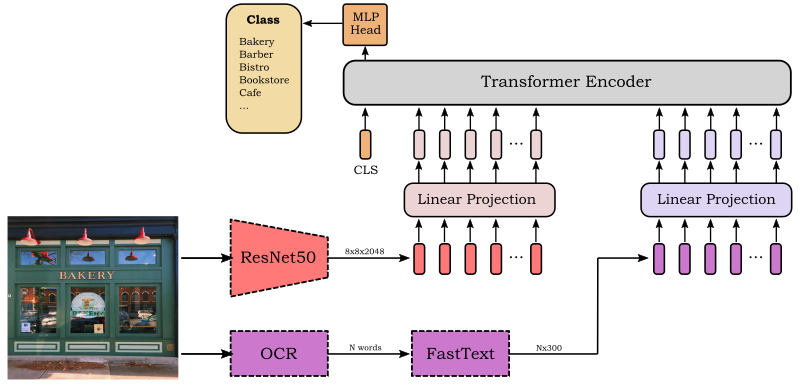

Let's start by installing and importing the necessary Python modules.

In [2]:
!pip install einops
!pip install fasttext-wheel
!pip install fasttext

# for the OCR module (see below)
!pip install opencv-python-headless==4.1.2.30
!pip install easyocr

  Using cached fasttext-0.9.2.tar.gz (68 kB)
  ERROR: Command errored out with exit status 1:
   command: /anaconda/envs/azureml_py38_PT_and_TF/bin/python -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-_jm64bn9/fasttext/setup.py'"'"'; __file__='"'"'/tmp/pip-install-_jm64bn9/fasttext/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d /tmp/pip-wheel-m37m84mh
       cwd: /tmp/pip-install-_jm64bn9/fasttext/
  Complete output (56 lines):
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build/lib.linux-x86_64-3.8
  creating build/lib.linux-x86_64-3.8/fasttext
  copying python/fasttext_module/fasttext/__init__.py -> build/lib.linux-x86_64-3.8/fasttext
  copying python/fasttext_module/fasttext/FastText.py -> build/lib.linux-x86_64-3.8/fasttext
  creating build/lib.linux-x86_64-3.8/fasttext/ut

In [3]:
from PIL import Image
import numpy as np
import easyocr

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torch.utils.data import Dataset

from einops import rearrange

import fasttext
import fasttext.util

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
print(torch.__version__)

cuda
1.12.0


We must download the pre-trained FastText model and load it into memory. Unfortunately this takes around 20 minutes in Colab. 

In [4]:
fasttext.util.download_model('en', if_exists='ignore')  # English
fasttext_model = fasttext.load_model('cc.en.300.bin')

## Define and create the model

Here we define the architecture of our model. See the comments in the code for better understanding. 

For the Transformer Encoder we use the built-in [PyTorch Transformer Layers](https://pytorch.org/docs/stable/nn.html#transformer-layers).

In [5]:
class ConTextTransformer(nn.Module):
    def __init__(self, *, image_size, num_classes, dim, depth, heads, mlp_dim, channels=3):
        super().__init__()

        # Visual feature extractor
        resnet50 = torchvision.models.resnet50(pretrained=True)
        modules=list(resnet50.children())[:-2]
        self.resnet50=nn.Sequential(*modules)
        for param in self.resnet50.parameters():
            param.requires_grad = False
        self.num_cnn_features = 64  # 8x8
        self.dim_cnn_features = 2048
        self.dim_fasttext_features = 300

        # Embeddings for the visual and textual features
        self.cnn_feature_to_embedding = nn.Linear(self.dim_cnn_features, dim)
        self.fasttext_feature_to_embedding = nn.Linear(self.dim_fasttext_features, dim)

        # Learnable position embeddings (for the visual features) and CLS token
        self.pos_embedding = nn.Parameter(torch.randn(1, self.num_cnn_features + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))

        # The Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=dim, nhead=heads, dim_feedforward=mlp_dim, batch_first=True)
        encoder_norm = nn.LayerNorm(dim)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=depth)

        # Classification Head (MLP)
        self.to_cls_token = nn.Identity()
        self.mlp_head = nn.Sequential(
            nn.Linear(dim, mlp_dim),
            nn.GELU(),
            nn.Linear(mlp_dim, num_classes)
        )

    def forward(self, img, txt, mask=None):
        x = self.resnet50(img)
        x = rearrange(x, 'b d h w -> b (h w) d') # this makes a sequence of 64 videual features
        x = self.cnn_feature_to_embedding(x)

        cls_tokens = self.cls_token.expand(img.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding

        x2 = self.fasttext_feature_to_embedding(txt.float())
        x = torch.cat((x,x2), dim=1)
        x = self.transformer(x)

        x = self.to_cls_token(x[:, 0])
        return self.mlp_head(x)

Now we can create our model and load the pre-trained weights. 

The particular model instance we use in this demo has only **two encoder layers with 4 heads**, the dimensions of embeddings and encoder linear layers are 256 and 512 respectively.

In [6]:
model = ConTextTransformer(image_size=256, num_classes=28, channels=3, dim=256, depth=2, heads=4, mlp_dim=512)

#!wget https://raw.githubusercontent.com/lluisgomez/ConTextTransformer/main/all_best.pth

model.load_state_dict(torch.load('all_best.pth'))
model.to(device)
model.eval()

/anaconda/envs/azureml_py38_PT_and_TF/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_and_TF/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ConTextTransformer(
  (resnet50): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0):

Here we define the image transformations, the class labels dictionary, and the inference method.

In [7]:
img_transforms = torchvision.transforms.Compose([
        torchvision.transforms.Resize(256),
        torchvision.transforms.CenterCrop(256),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

class_labels = {1: "Bakery", 2: "Barber", 3: "Bistro", 4: "Bookstore", 5: "Cafe", 6: "ComputerStore", 7: "CountryStore", 8: "Diner", 9: "DiscounHouse", 10: "Dry Cleaner", 11: "Funeral", 12: "Hotspot", 13: "MassageCenter", 14: "MedicalCenter", 15: "PackingStore", 16: "PawnShop", 17: "PetShop", 18: "Pharmacy", 19: "Pizzeria", 20: "RepairShop", 21: "Restaurant", 22: "School", 23: "SteakHouse", 24: "Tavern", 25: "TeaHouse", 26: "Theatre", 27: "Tobacco", 28: "Motel"}

def context_inference(img_filename, OCR_tokens):
  img = Image.open(img_filename).convert('RGB')
  img = img_transforms(img)
  img = torch.unsqueeze(img, 0)
  
  text = np.zeros((1, 64, 300))
  for i,w in enumerate(OCR_tokens):
    text[0,i,:] = fasttext_model.get_word_vector(w)

  output = F.softmax(model(img.to(device), torch.tensor(text).to(device)), dim=1)
  return output.cpu().detach().numpy()

## ConText inference demo

We have everything ready to do some inference experiments with the pre-trained model. Let's start by downloading one image for testing.

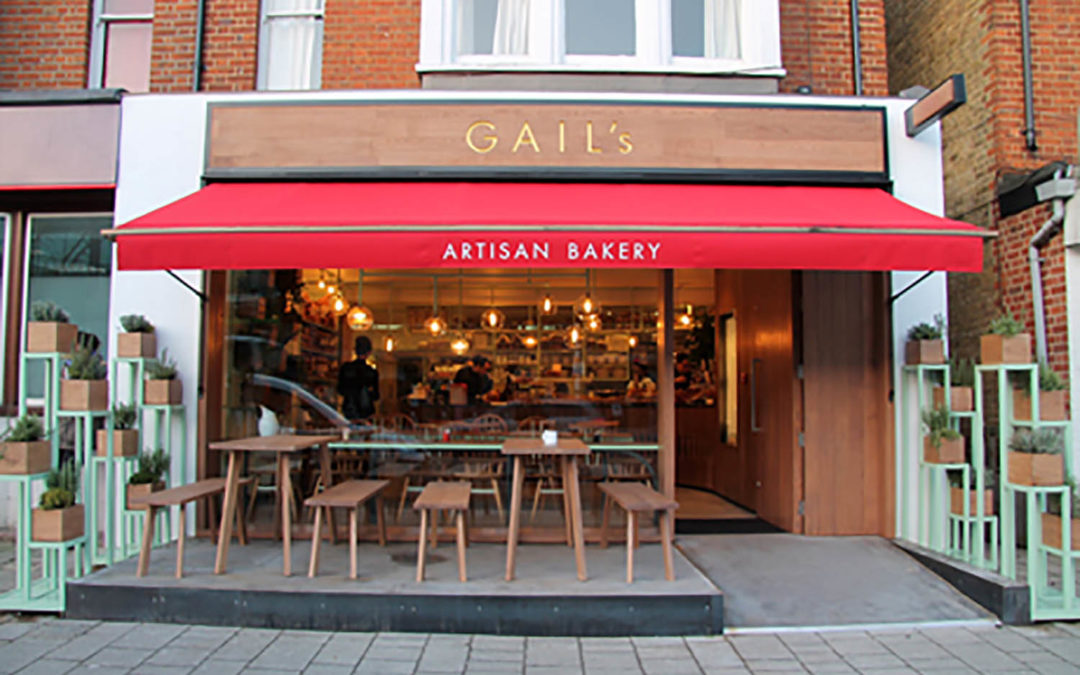

In [8]:
!wget -q https://gailsbread.co.uk/wp-content/uploads/2017/11/Summertown-1080x675.jpg

from IPython.display import Image as ShowImage
ShowImage('Summertown-1080x675.jpg')

Now lets see how our model classifies the image depending if we use some textual information or not. For the moment we simulate the OCR output with a hard-coded list of words (*OCR_tokens*).

In [9]:
OCR_tokens = [] # Let's imagine our OCR model does not recognize any text

probs = context_inference('Summertown-1080x675.jpg', OCR_tokens)
class_id = np.argmax(probs)
print('Prediction without text: {} ({})'.format(class_labels[class_id+1], probs[0,class_id]))


OCR_tokens = ['GAIL', 'ARTISAN', 'BAKERY'] # Simulate a perfect OCR output

probs = context_inference('Summertown-1080x675.jpg', OCR_tokens)
class_id = np.argmax(probs)
print('Prediction with text:\t {} ({})'.format(class_labels[class_id+1], probs[0,class_id]))

Prediction without text: Diner (0.3832745850086212)
Prediction with text:	 Bakery (0.9980818033218384)


Now we can play a bit with the model ... try different images, contraste the predictions when using different words as OCR tokens, simulate OCR errors, etc.

In [10]:
# add your code here ... 

## Adding the OCR module for a fully functional system

There are different options for integrating a pre-trained OCR module. 

A typical photo-OCR pipeline would require two pre-trained models: one for text detection (e.g. [EAST](https://github.com/ZER-0-NE/EAST-Detector-for-text-detection-using-OpenCV) or [CRAFT](https://github.com/clovaai/CRAFT-pytorch)) and another for text recognition (e.g. from the [CLOVA recognition repo](https://github.com/clovaai/deep-text-recognition-benchmark)). An alternative is to use an end-to-end model that performs both detection and recognition (e.g. [MaskTextSpotterV3](https://github.com/MhLiao/MaskTextSpotterV3)).

All the models' repositories linked above have publicly available pre-trained weigths and code that one can integrate in a fully functional multi-modal system. However they require some installation steps and "glue" code that is not very practical for a notebook. For this reason we are going to use here a simpler alternative based on open source solution: the [EasyOCR](https://github.com/JaidedAI/EasyOCR) Python package. It is a cool project that aims at making state of the art text detection and recognition models quickly accessible to the public for free.

In [11]:
# this needs to run only once to load the model into memory
reader = easyocr.Reader(['en']) # English text recognition model

In [12]:
def detect_text(img_filename):
    """Detects text in the image using EasyOCR"""
    results = reader.readtext(img_filename)
   
    words, boxes, confs = [], [], []
    for res in results:
        boxes.append(res[0])
        words.append(res[1])
        confs.append(res[2])
        
    return words, boxes, confs

Now we can directly call our model using the output of the OCR API as our *OCR_tokens*.

In [13]:
# img_filename = 'Summertown-1080x675.jpg'
# OCR_tokens,_,_ = detect_text(img_filename)
# probs = context_inference(img_filename, OCR_tokens)
# class_id = np.argmax(probs)
# print('Detected text: {}'.format(OCR_tokens))
# print('Prediction: {} ({})'.format(class_labels[class_id+1], probs[0,class_id]))

In [14]:
import time,os,json
from PIL import Image
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torch.utils.data import Dataset

CREATE TEST JSON FILES

In [15]:
data = {}
data['test_and_validation'] = []

for i in range(1,29):
    with open(f'./features/data/ImageSets/0/{i}_test.txt', 'r') as file:
        # Iterate over each line in the file
        for line in file:
            # Remove any leading/trailing whitespace characters (like newline)
            line = line.strip()
            # Split the line into filename and label
            filename, label = line.split('\t')
            # Add the filename and label to the dictionary
            label = int(label)
            if label == -1:
                continue
            else:
                data['test_and_validation'].append((filename, i))

print(len(data['test_and_validation']))

8076


In [16]:
data['validation'] = []
data['test'] = []

samples = data['test_and_validation']

start_index = 0

for i in range(1,29):
    category_samples = 0
    end_index = start_index
    while end_index < len(samples):
        if samples[end_index][1] == i:
            end_index += 1
        else:
            break

    distance = end_index - start_index
    middle_index = start_index + distance / 2 if distance % 2 == 0 else start_index + (distance - 1) / 2
    middle_index = int(middle_index)
    for j in range(start_index, middle_index):
        data['test'].append(samples[j])
    for j in range(middle_index, end_index):
        data['validation'].append(samples[j])

    start_index = end_index

print(data['test'])
print(data['validation'])
print(len(data['test']))
print(len(data['validation']))

[('n02776631_26078', 1), ('n02776631_19456', 1), ('n02776631_12272', 1), ('n02776631_19279', 1), ('n02776631_42346', 1), ('n02776631_7853', 1), ('n02776631_33748', 1), ('n02776631_11801', 1), ('n02776631_32502', 1), ('n02776631_13182', 1), ('n02776631_1654', 1), ('n02776631_26821', 1), ('n02776631_6994', 1), ('n02776631_2421', 1), ('n02776631_5622', 1), ('n02776631_6622', 1), ('n02776631_18049', 1), ('n02776631_50572', 1), ('n02776631_6151', 1), ('n02776631_29862', 1), ('n02776631_15546', 1), ('n02776631_14533', 1), ('n02776631_6892', 1), ('n02776631_15395', 1), ('n02776631_29539', 1), ('n02776631_10585', 1), ('n02776631_9416', 1), ('n02776631_26996', 1), ('n02776631_17342', 1), ('n02776631_18277', 1), ('n02776631_10753', 1), ('n02776631_10454', 1), ('n02776631_1991', 1), ('n02776631_54847', 1), ('n02776631_4048', 1), ('n02776631_14914', 1), ('n02776631_7264', 1), ('n02776631_9806', 1), ('n02776631_15783', 1), ('n02776631_27368', 1), ('n02776631_7946', 1), ('n02776631_13184', 1), ('n02

CREATE TRAIN JSON FILES

In [17]:
data['train'] = []

for i in range(1,29):
    with open(f'./features/data/ImageSets/0/{i}_train.txt', 'r') as file:
        # Iterate over each line in the file
        for line in file:
            # Remove any leading/trailing whitespace characters (like newline)
            line = line.strip()
            # Split the line into filename and label
            filename, label = line.split('\t')
            # Add the filename and label to the dictionary
            label = int(label)
            if label == -1:
                continue
            else:
                data['train'].append((filename, i))

print(len(data['test']))
print(len(data['train']))

4034
16179


In [18]:
train_counter = {}

for i in range(1,29):
    train_counter[i] = 0
for i in data['train']:
    train_counter[i[1]] += 1

print(train_counter)
sum = 0
for s in train_counter.values():
    sum += s

print(sum)

{1: 810, 2: 1049, 3: 192, 4: 889, 5: 560, 6: 192, 7: 816, 8: 758, 9: 29, 10: 797, 11: 661, 12: 50, 13: 186, 14: 806, 15: 778, 16: 330, 17: 416, 18: 850, 19: 761, 20: 514, 21: 801, 22: 922, 23: 218, 24: 156, 25: 474, 26: 928, 27: 484, 28: 752}
16179


In [19]:
test_and_validate_counter = {}

for i in range(1,29):
    test_and_validate_counter[i] = 0
for i in data['test_and_validation']:
    test_and_validate_counter[i[1]] += 1

print(test_and_validate_counter)
sum = 0
for s in test_and_validate_counter.values():
    sum += s

print(sum)

{1: 404, 2: 524, 3: 95, 4: 444, 5: 279, 6: 95, 7: 408, 8: 378, 9: 14, 10: 398, 11: 330, 12: 24, 13: 92, 14: 403, 15: 389, 16: 165, 17: 208, 18: 425, 19: 380, 20: 256, 21: 400, 22: 461, 23: 108, 24: 78, 25: 236, 26: 464, 27: 242, 28: 376}
8076


TRANSFORM TO JSON

In [20]:
import json

with open('./annotations/split_0.json', 'w') as json_file:
    json.dump(data, json_file, indent=4)

CREATE ANNOTATIONS FOR EVERY TEST FILE

In [21]:
# this needs to run only once to load the model into memory
reader = easyocr.Reader(['en']) # English text recognition model

In [22]:
def detect_text(img_filename):
    """Detects text in the image using EasyOCR"""
    results = reader.readtext(img_filename)
   
    words, boxes, confs = [], [], []
    for res in results:
        boxes.append(res[0])
        words.append(res[1])
        confs.append(res[2])
        
    return words, boxes, confs

In [23]:
# samples = data['test']
# i = 0

# for filename, label in samples:
#     json_annotation_dict = {}
#     json_annotation_dict['textAnnotations'] = [{'nimic': 0}]
#     OCR_tokens,_,_ = detect_text(f'./images/data/JPEGImages/{filename}.jpg')
#     for token in OCR_tokens:
#         json_annotation_dict['textAnnotations'].append({'description':token})
#     with open(f'./ocr_labels/{filename}.json', 'w') as json_file:
#         json.dump(json_annotation_dict, json_file, indent=4)



CREATE ANNOTATIONS FOR EVERY TEST FILE

In [24]:
# samples = data['train']
# i = 0

# for filename, label in samples:
#     json_annotation_dict = {}
#     json_annotation_dict['textAnnotations'] = [{'nimic': 0}]
#     OCR_tokens,_,_ = detect_text(f'./images/data/JPEGImages/{filename}.jpg')
#     for token in OCR_tokens:
#         json_annotation_dict['textAnnotations'].append({'description':token})
#     with open(f'./ocr_labels/{filename}.json', 'w') as json_file:
#         json.dump(json_annotation_dict, json_file, indent=4)



In [41]:

class ConTextDataset(Dataset):
    def __init__(self, json_file, root_dir, root_dir_txt, train=True, transform=None):
        with open(json_file) as f:
            data = json.load(f)
        self.train = train
        self.root_dir = root_dir
        self.root_dir_txt = root_dir_txt
        self.transform = transform
        if (self.train):
            self.samples = data['train']
        else:
            self.samples = data['test_and_validation']

        fasttext.util.download_model('en', if_exists='ignore')  # English
        self.fasttext = fasttext.load_model('cc.en.300.bin')
        self.dim_fasttext = self.fasttext.get_dimension()
        self.max_num_words = 64


    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_name = os.path.join(self.root_dir, self.samples[idx][0]+'.jpg')
        image = Image.open(img_name).convert('RGB')
        if self.transform:
            image = self.transform(image)

        text = np.zeros((self.max_num_words, self.dim_fasttext))
        text_mask = np.ones((self.max_num_words,), dtype=bool)
        text_name = os.path.join(self.root_dir_txt, self.samples[idx][0]+'.json')
        with open(text_name) as f:
            data = json.load(f)

        words = []
        if 'textAnnotations' in data.keys():
            for i in range(1,len(data['textAnnotations'])):
                word = data['textAnnotations'][i]['description']
                if len(word) > 2: words.append(word)

        words = list(set(words))
        for i,w in enumerate(words):
            if i>=self.max_num_words: break
            text[i,:] = self.fasttext.get_word_vector(w)
            text_mask[i] = False
        
        target = self.samples[idx][1] - 1

        return image, text, text_mask, target

In [26]:
img_dir = './data/JPEGImages'
json_file = './annotations/split_0.json'
txt_dir = "./ocr_labels/"
validation_dir = './validation'
input_size = 256

data_transforms_test = torchvision.transforms.Compose([
        torchvision.transforms.Resize(input_size),
        torchvision.transforms.CenterCrop(input_size),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])


In [42]:
test_set  = ConTextDataset(json_file, img_dir, txt_dir, False, data_transforms_test)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False, num_workers=8)

In [62]:
def evaluate(model, data_loader, dataset, loss_history):
    model.eval()

    class_correct = {}  # Dictionary to count correct samples for each class
    class_total = {}    # Dictionary to count total samples for each class
    for i in range(1, 29):
        class_correct[i] = 0
        class_total[i] = 0

    total_samples = len(data_loader.dataset)
    correct_samples = 0
    total_loss = 0
    misclassified_images = []  # List to store misclassified image names
    misclassified_labels = []  # List to store the wrong predictions for the misclassified images

    with torch.no_grad():
        for batch_idx, (data_img, data_txt, txt_mask, target) in enumerate(data_loader):
            data_img = data_img.to(device)
            data_txt = data_txt.to(device)
            txt_mask = txt_mask.to(device)
            target = target.to(device)
            output = F.log_softmax(model(data_img, data_txt, txt_mask), dim=1)
            loss = F.nll_loss(output, target, reduction='sum')
            _, pred = torch.max(output, dim=1)

            total_loss += loss.item()
            correct_samples += pred.eq(target).sum()

            for i, (t, p) in enumerate(zip(target, pred)):
                class_total[t.item() + 1] += 1
                if t == p:
                    class_correct[t.item() + 1] += 1
                else:
                    img_index = batch_idx * data_loader.batch_size + i
                    image_name = dataset.samples[img_index][0]  # Adjust this to match how you store image names
                    misclassified_images.append(image_name)  # Store misclassified image name
                    misclassified_labels.append((t.item(), p.item()))  # Store true and predicted labels

    print(class_correct)
    print(class_total)

    avg_loss = total_loss / total_samples
    loss_history.append(avg_loss)
    print('\nAverage test loss: ' + '{:.4f}'.format(avg_loss) +
          '  Accuracy:' + '{:5}'.format(correct_samples) + '/' +
          '{:5}'.format(total_samples) + ' (' +
          '{:4.2f}'.format(100.0 * correct_samples / total_samples) + '%)\n')

    return correct_samples / total_samples, class_correct, class_total, misclassified_images, misclassified_labels


In [65]:
def test_saved_model(model_path, test_loader):
    # Initialize the model
    model = ConTextTransformer(image_size=input_size, num_classes=28, channels=3, dim=256, depth=3, heads=4, mlp_dim=512)
    
    # Load the model state from the saved file
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    
    # Set the model to evaluation mode
    model.eval()
    
    # Initialize a list to keep track of the test loss
    test_loss_history = []
    
    # Evaluate the model and print the accuracy
    accuracy, class_correct, class_total, mis_img, mis_label = evaluate(model, test_loader, test_set, test_loss_history)
    print(f'Test accuracy of the saved model: {accuracy:.2f}%')
    
    return accuracy, class_correct, class_total, mis_img, mis_label

In [66]:
model_path = 'our_all_best.pth'
acc, class_correct, class_total, mis_img, mis_label = test_saved_model(model_path, test_loader)

/anaconda/envs/azureml_py38_PT_and_TF/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_and_TF/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/anaconda/envs/azureml_py38_PT_and_TF/lib/python3.8/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker cre

{1: 333, 2: 456, 3: 28, 4: 393, 5: 125, 6: 61, 7: 266, 8: 271, 9: 2, 10: 309, 11: 221, 12: 19, 13: 70, 14: 256, 15: 253, 16: 90, 17: 162, 18: 296, 19: 290, 20: 160, 21: 284, 22: 318, 23: 43, 24: 34, 25: 134, 26: 387, 27: 143, 28: 288}
{1: 404, 2: 524, 3: 95, 4: 444, 5: 279, 6: 95, 7: 408, 8: 378, 9: 14, 10: 398, 11: 330, 12: 24, 13: 92, 14: 403, 15: 389, 16: 165, 17: 208, 18: 425, 19: 380, 20: 256, 21: 400, 22: 461, 23: 108, 24: 78, 25: 236, 26: 464, 27: 242, 28: 376}

Average test loss: 1.0816  Accuracy: 5692/ 8076 (70.48%)

Test accuracy of the saved model: 0.70%


In [56]:
# for i in range(1,29):
#     print(f"Class {i}: {train_counter[i]/len(data['train'])*100}%({train_counter[i]}) has accuracy of: {class_correct[i]/class_total[i]*100}%")

perc = {}
for i in range(1,29):
    perc[i] = class_correct[i]/class_total[i]

sorted_keys = sorted(perc, key=perc.get, reverse=True)

for i in sorted_keys:
    print(f"Class {i} has accuracy {perc[i]*100} and has {train_counter[i]} samples ")

print(perc)
print(sorted_keys)

Class 4 has accuracy 88.51351351351352 and has 889 samples 
Class 2 has accuracy 87.02290076335878 and has 1049 samples 
Class 26 has accuracy 83.40517241379311 and has 928 samples 
Class 1 has accuracy 82.42574257425743 and has 810 samples 
Class 12 has accuracy 79.16666666666666 and has 50 samples 
Class 17 has accuracy 77.88461538461539 and has 416 samples 
Class 10 has accuracy 77.63819095477386 and has 797 samples 
Class 28 has accuracy 76.59574468085107 and has 752 samples 
Class 19 has accuracy 76.31578947368422 and has 761 samples 
Class 13 has accuracy 76.08695652173914 and has 186 samples 
Class 8 has accuracy 71.6931216931217 and has 758 samples 
Class 21 has accuracy 71.0 and has 801 samples 
Class 18 has accuracy 69.6470588235294 and has 850 samples 
Class 22 has accuracy 68.98047722342733 and has 922 samples 
Class 11 has accuracy 66.96969696969697 and has 661 samples 
Class 7 has accuracy 65.19607843137256 and has 816 samples 
Class 15 has accuracy 65.03856041131105 and 

In [68]:
print(len(mis_img), len(mis_label))

2384 2384


In [67]:
for img, label in zip(mis_img, mis_label):
    print(img, label)

n02776631_7853 (0, 1)
n02776631_11801 (0, 4)
n02776631_32502 (0, 24)
n02776631_13182 (0, 24)
n02776631_1654 (0, 6)
n02776631_6994 (0, 9)
n02776631_6622 (0, 21)
n02776631_6892 (0, 5)
n02776631_15395 (0, 7)
n02776631_26996 (0, 9)
n02776631_27368 (0, 14)
n02776631_34663 (0, 6)
n02776631_2589 (0, 6)
n02776631_41176 (0, 18)
n02776631_5937 (0, 4)
n02776631_16289 (0, 18)
n02776631_33095 (0, 18)
n02776631_29278 (0, 24)
n02776631_34755 (0, 25)
n02776631_33306 (0, 3)
n02776631_25391 (0, 26)
n02776631_32583 (0, 18)
n02776631_10649 (0, 15)
n02776631_10142 (0, 26)
n02776631_18395 (0, 7)
n02776631_28595 (0, 18)
n02776631_12232 (0, 1)
n02776631_14249 (0, 4)
n02776631_14431 (0, 1)
n02776631_11064 (0, 20)
n02776631_12748 (0, 6)
n02776631_5029 (0, 4)
n02776631_43110 (0, 24)
n02776631_34580 (0, 18)
n02776631_16210 (0, 7)
n02776631_2953 (0, 6)
n02776631_8614 (0, 24)
n02776631_22906 (0, 18)
n02776631_28764 (0, 18)
n02776631_25836 (0, 10)
n02776631_2005 (0, 25)
n02776631_5412 (0, 18)
n02776631_4712 (0, 6)
n